<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/04_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook
!pip install datasets

In [7]:
import datasets
import diffusers
import huggingface_hub

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
from diffusers import UNet2DModel

from datasets import load_dataset

from genaibook.core import get_device
from genaibook.core import plot_noise_and_denoise
from genaibook.core import show_images
from genaibook.core import load_image, SampleURL
from genaibook.core import plot_scheduler

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

In [4]:
device = get_device()

## Iterative Refinement

In [ ]:
# Load the pipeline
image_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

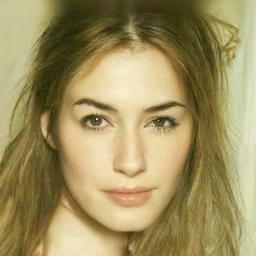

In [ ]:
# Sample an image
image = image_pipeline().images[0]
image

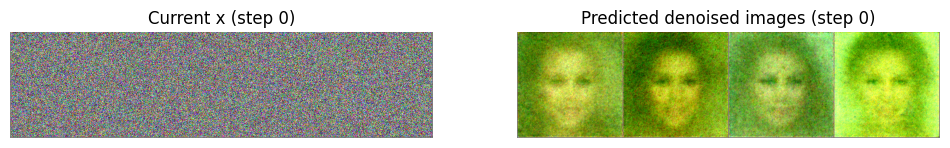

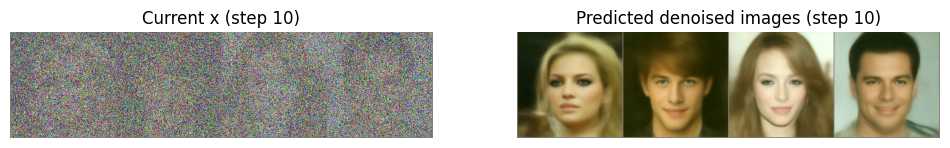

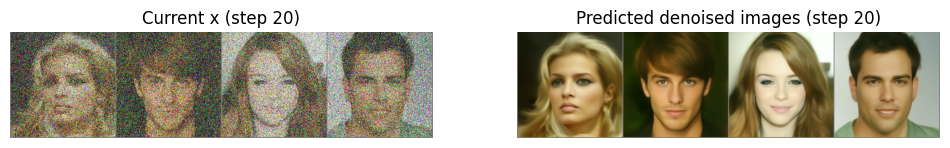

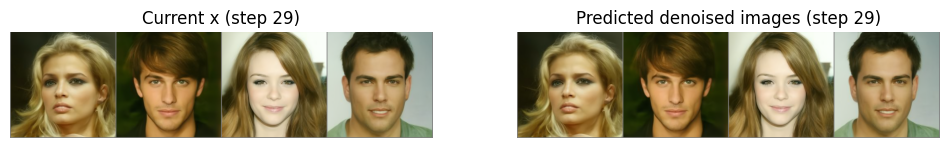

In [ ]:
# The random starting point is a batch of 4 images
# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)

# Set the specific number of diffusion steps
image_pipeline.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipeline.scheduler.timesteps):
  # # Get the prediction given the current sample x and the timestep t
  with torch.inference_mode():
    # We need to pass in the timestep t so that the model knows what timestep it's currently at.
    noise_pred = image_pipeline.unet(image, t)["sample"]
  # Calculate what the updated x should look like with the scheduler
  scheduler_output = image_pipeline.scheduler.step(noise_pred, t, image)

  # Update x
  image = scheduler_output.prev_sample

  # Occasionally display both x and the predicted denoised images
  if i % 10 == 0 or i == len(image_pipeline.scheduler.timesteps) - 1:
    plot_noise_and_denoise(scheduler_output, i)

## Training Diffusion Model

###Dataset

In [ ]:
# let's load dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

In [ ]:
image_size = 64

# Define transformations
preprocess = transforms.Compose(
   [
       transforms.Resize((image_size, image_size)), # Resize
      transforms.RandomHorizontalFlip(),            # Randomly flip (data augmentation)
      transforms.ToTensor(),                        # Convert to tensor (0, 1)
      transforms.Normalize([0.5], [0.5]),           # Map to (-1, 1)
   ]
)

In [ ]:
def transform(examples):
  images = [preprocess(image) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)

In [ ]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

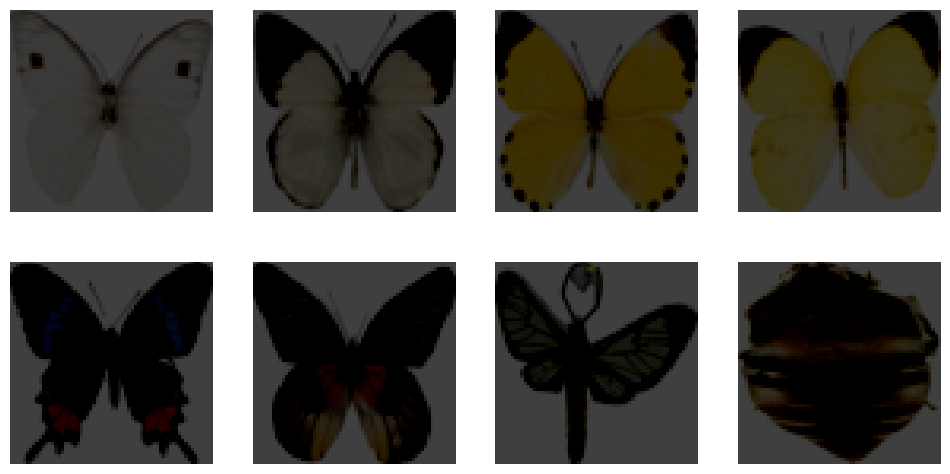

In [ ]:
# let's load a batch and inspecting the images
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images((batch["images"][:8] * 0.5 * 0.5).clip(0, 1))

### Add Noise

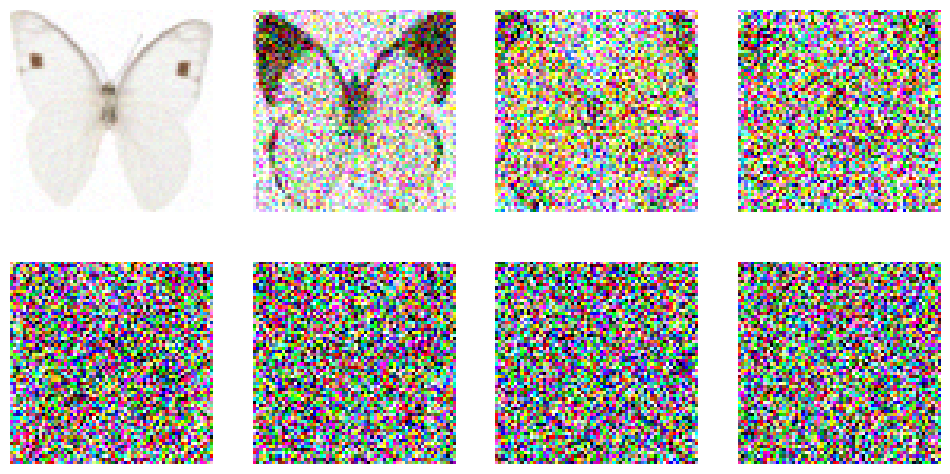

In [ ]:
# adding noise is handled by a class called a Scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.001,
    beta_end=0.02,
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.randn_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images((noised_x * 0.5 + 0.5).clip(0, 1))

###The UNet

In [ ]:
# let's create a UNet and feed our batch of noisy images through it
model = UNet2DModel(
    sample_size=64, # Specify our input size
    in_channels=3,  # 3 channels for RGB images
    block_out_channels=(64, 128, 256, 512), # How many channels each block will have
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
).to(device)

In [ ]:
# Pass a batch of data through to make sure it works
with torch.inference_mode():
  output = model(noised_x.to(device), timestep=timesteps.to(device)).sample
print(noised_x.shape)
print(output.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


###Training

In [ ]:
batch_size = 32

def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

# We reset to the initial size (64)
dataset.set_transform(transform)
image_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
num_epochs = 50 # How many runs through the data should we do?
lr = 1e-4       # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []     # Somewhere to store the loss values for later plotting

# Train the model (this takes a while)
for epoch in range(num_epochs):
  for batch in train_dataloader:
    # Load the input images
    clean_images = batch["images"].to(device)

    # Sample noise to add to the images
    noise = torch.randn(clean_images.shape).to(device)

    # Sample a random timestep for each image
    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (clean_images.shape[0],),
        device=device,
    ).long()

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

    # Get the model prediction for the noise
    # The model also uses the timestep as an input
    # for additional conditioning
    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

    # Compare the prediction with the actual noise
    loss = F.mse_loss(noise_pred, noise)

    # Store the loss for later plotting
    losses.append(loss.item())

    # Backpropagate the loss and update the model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Print out the average of the loss values for this epoch:
  avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
  print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

Finished epoch 0. Average loss for this epoch: 0.441184
Finished epoch 1. Average loss for this epoch: 0.116829
Finished epoch 2. Average loss for this epoch: 0.086401
Finished epoch 3. Average loss for this epoch: 0.073533
Finished epoch 4. Average loss for this epoch: 0.064399
Finished epoch 5. Average loss for this epoch: 0.048374
Finished epoch 6. Average loss for this epoch: 0.047042
Finished epoch 7. Average loss for this epoch: 0.038915
Finished epoch 8. Average loss for this epoch: 0.040829
Finished epoch 9. Average loss for this epoch: 0.037490
Finished epoch 10. Average loss for this epoch: 0.033312
Finished epoch 11. Average loss for this epoch: 0.031120
Finished epoch 12. Average loss for this epoch: 0.029724
Finished epoch 13. Average loss for this epoch: 0.029665
Finished epoch 14. Average loss for this epoch: 0.031861
Finished epoch 15. Average loss for this epoch: 0.026527
Finished epoch 16. Average loss for this epoch: 0.027020
Finished epoch 17. Average loss for this 

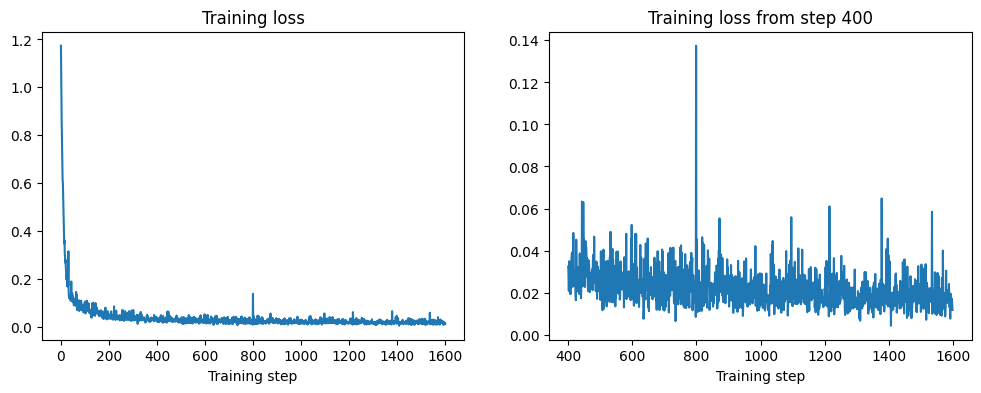

In [ ]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

###Sampling

  0%|          | 0/1000 [00:00<?, ?it/s]

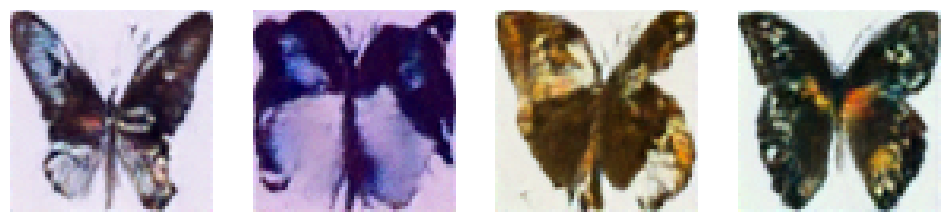

In [ ]:
# let’s do inference and generate some images
pipeline = DDPMPipeline(
    unet=model,
    scheduler=scheduler,
)

images = pipeline(batch_size=4).images
show_images(images, nrows=1)

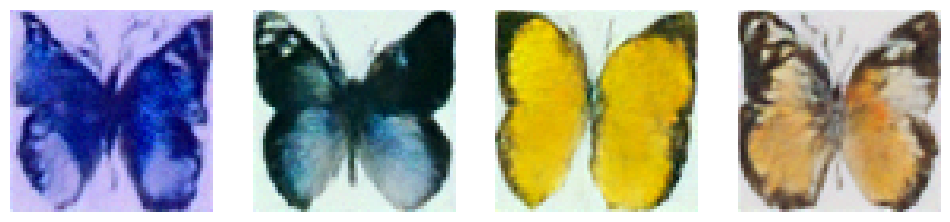

In [ ]:
# let’s do a simple sampling loop showing how the model gradually refines the input image
sample = torch.randn(4, 3, 64, 64).to(device) # Random starting point (4 random images)

for t in scheduler.timesteps:
  # Get the model prediction
  with torch.inference_mode():
    noise_pred = model(sample, t)["sample"]
  # Update sample with step
  sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)

##Noise Schedules

In [ ]:
x = next(iter(train_dataloader))["images"][:8].to(device)
noise = torch.rand_like(x)

In [ ]:
def corrupt(x, noise, amount):
  # Reshape amount so it works correctly with the original data
  amount = amount.view(-1, 1, 1, 1) # make sure it's broadcastable

  # Blend the original data and noise based on the amount
  return x * (1 - amount) + noise * amount # equivalent to x.lerp(noise, amount)

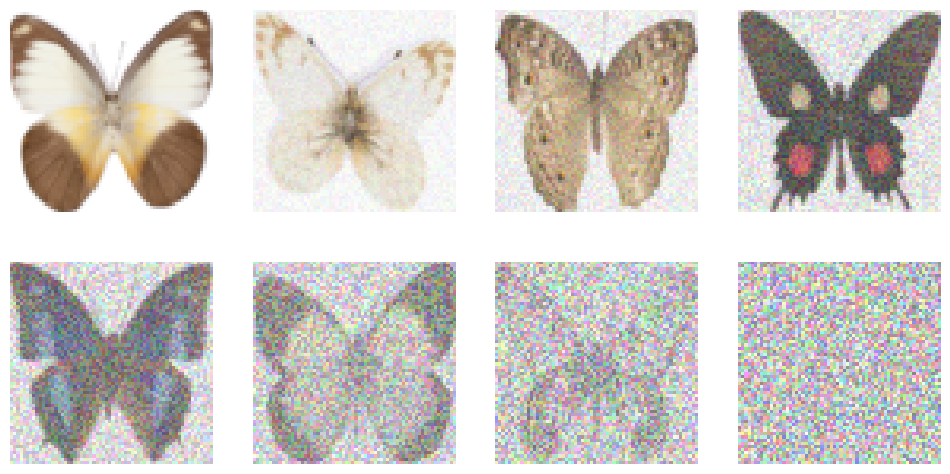

In [ ]:
# Let’s see this in action on a batch of data, with the amount of noise varying from 0 to 1
amount = torch.linspace(0, 1, 8).to(device)
noised_x = corrupt(x, noise, amount)
show_images(noised_x * 0.5 + 0.5)

In [ ]:
class SimpleScheduler:
  def __init__(self):
    self.num_train_timesteps = 1000

  def add_noise(self, x, noise, timesteps):
    amount = timesteps / self.num_train_timesteps
    return corrupt(x, noise, amount)

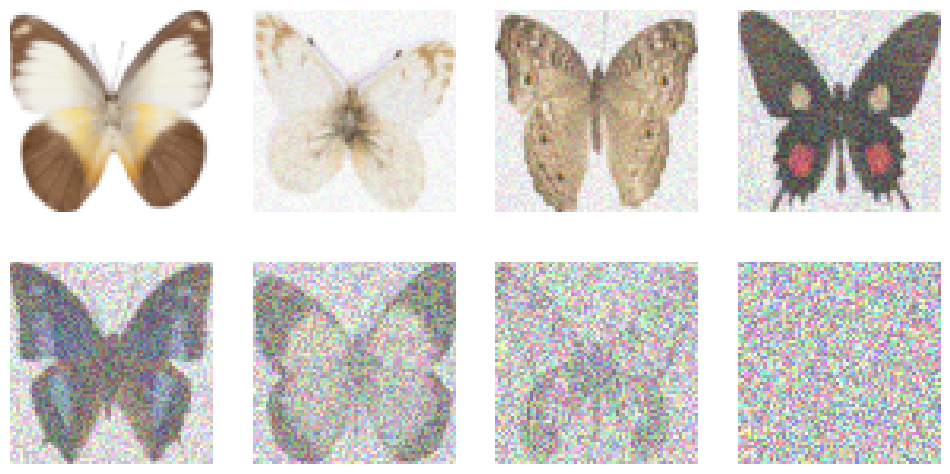

In [ ]:
scheduler = SimpleScheduler()
timesteps = torch.linspace(0, 999, 8).long().to(device)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images(noised_x * 0.5 + 0.5)

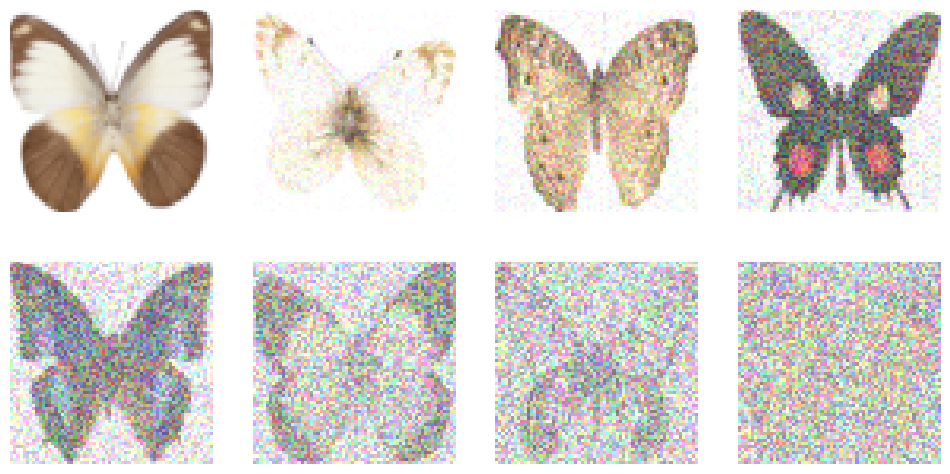

In [ ]:
# let's compare to the schedulers used in the diffusers library
scheduler = DDPMScheduler(beta_end=0.01)
timesteps = torch.linspace(0, 999, 8).long().to(device)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [ ]:
# let's see that the noise is scaled up more as we have more timesteps
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.02, beta_schedule="linear"),
)

In [ ]:
plot_scheduler(SimpleScheduler())

In [ ]:
# Let’s visualize the comparison of different DDPMScheduler schedulers
fig, (ax) = plt.subplots(1, 1, figsize=(8, 5))
plot_scheduler(
    DDPMScheduler(beta_schedule="linear"),
    label="default schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_schedule="squaredcos_cap_v2"),
    label="cosine schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.003, beta_schedule="linear"),
    label="Low beta_end",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.1, beta_schedule="linear"),
    label="High beta_end",
    ax=ax,
    plot_both=False,
)

In [ ]:
# let's see the effect of input resolution and scaling
scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")
image = load_image(
    "https://images.pexels.com/photos/15403949/pexels-photo-15403949.jpeg",
    size=((512, 512)),
    return_tensor=True,
)
small_image = transforms.functional.resize(image, 64, antialias=True)
t = torch.tensor(500)  # The timestep we're noising to
show_images(
    [
        image,
        scheduler.add_noise(image * 2 - 1, torch.randn_like(image), t).clip(
            -1, 1
        )
        * 0.5
        + 0.5,
        scheduler.add_noise(
            small_image * 2 - 1, torch.randn_like(small_image), t
        ).clip(-1, 1)
        * 0.5
        + 0.5,
    ],
    titles=["Original", "Noisy (t=500, size=512)", "Noisy (t=500, size=64)"],
    figsize=(15, 5),
)

In [ ]:
scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")
image = load_image(
    SampleURL.DogExample,
    size=((512, 512)),
    return_tensor=True,
)

t = torch.tensor(300)  # The timestep we're noising to
scales = np.linspace(0.1, 1.0, 4)

images = [image]
noise = torch.randn_like(image)
for b in reversed(scales):
    noised = (
        scheduler.add_noise(b * (image * 2 - 1), noise, t).clip(-1, 1) * 0.5
        + 0.5
    )
    images.append(noised)

show_images(
    images[1:],
    nrows=1,
    titles=[f"Scale: {b}" for b in reversed(scales)],
    figsize=(15, 5),
)

##UNets and Alternatives

In [6]:
class BasicUNet(nn.Module):
  """A minimal UNet implementation."""
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.down_layers = nn.ModuleList(
        [
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ]
    )
    self.up_layers = nn.ModuleList(
        [
            nn.ConvTranspose2d(64, 64, kernel_size=5, padding=2),
            nn.ConvTranspose2d(64, 32, kernel_size=5, padding=2),
            nn.ConvTranspose2d(32, out_channels, kernel_size=5, padding=2),
        ]
    )
    # Use the SiLU activation function, which has been shown to work well
    # due to different properties (smoothness, non-monotonicity, etc.).
    self.act = nn.SiLU()
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2)

  def forward(self, x):
    h = []
    for i , l in enumerate(self.down_layers):
      x = self.act(l(x))
      if i < 2:  # For all but the third (final) down layer
        h.append(x) # Storing output for skip connection
        x = self.downscale(x) # Downscale ready for the next layer
    for i, l in enumerate(self.up_layers):
      # For all except the first up layer
      if i > 0:
        x = self.upscale(x) # Upscale
        x += h.pop() # Fetching stored output (skip connection)
      x = self.act(l(x))
    return x

###Exploring data

In [ ]:
# loading the data with the datasets library
dataset = load_dataset("mnist")

In [9]:
image_size = 32
batch_size = 8

def transform(examples):
  examples = [preprocess(image) for image in examples["image"]]
  return {"images": examples}

dataset.set_transform(transform)

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Input shape: torch.Size([8, 1, 32, 32])


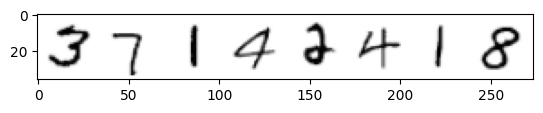

In [10]:
imgs = next(iter(train_dataloader))["images"]
print("Input shape:", imgs.shape)
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys");

###Corruption

In [12]:
# Let's add some amount of configurable noise to the input images
def corrupt(x, noise, amount):
  amount = amount.view(-1, 1, 1, 1) # make sure it's broadcastable
  # equivalent to x.lerp(noise, amount)
  return (x * (1 - amount) + noise * amount)

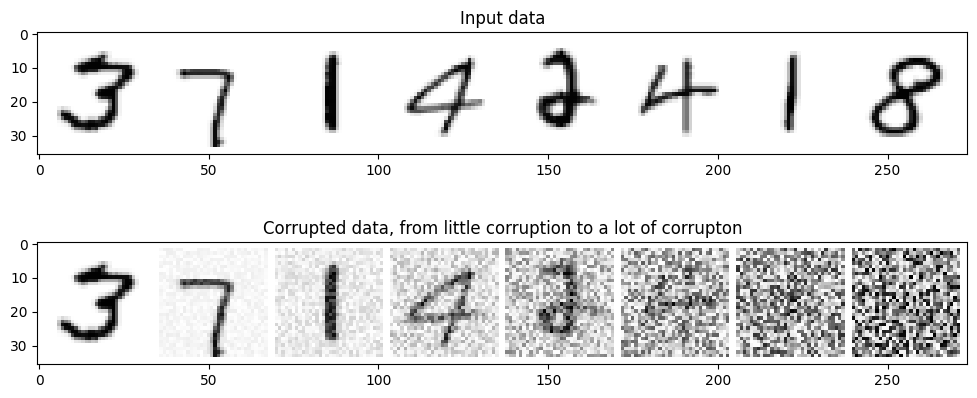

In [13]:
# Let's visualize the effect of applying noise to the images.

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

# Adding noise (we go from little corruption to a lot)
amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data, from little corruption to a lot of corrupton")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

### Basic UNet